In [221]:
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torchvision.io import read_image
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from torch import optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from tqdm import tqdm


In [222]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
seed = 99

Using cpu device


In [223]:
## Define custom dataset

class CustomDatasetFromCSV(Dataset):
    def __init__(self, csv_path, height, width,status,transforms=None):
        self.data = pd.read_csv(csv_path)
        self.labels = np.asarray(self.data.iloc[:, 0])
        self.height = height
        self.width = width
        self.transforms = transforms
        self.status = status
        
    def __getitem__(self, index):
        single_image_label = self.labels[index]        
        img_as_np = np.asarray(self.data.iloc[index][self.status:]).reshape(28,28).astype('uint8')	
        
        mean_px = np.mean(img_as_np).astype(np.float32)
        std_px = np.std(img_as_np).astype(np.float32)
        img_as_np = (img_as_np - mean_px)/(std_px)        
        
        img_as_img = Image.fromarray(img_as_np)
        
        #transform image to tensor
        img_as_img = img_as_img.convert('L')    
        if self.transforms is not None:
            img_as_tensor = self.transforms(img_as_img)       
        return (img_as_tensor, single_image_label)

    def __len__(self):
        return len(self.data.index)

In [224]:
## Create custom dataset
transformations = transforms.Compose([transforms.ToTensor()])
imageData = CustomDatasetFromCSV('./train.csv',784,784,1, transformations)
#testData = CustomDatasetFromCSV('./test.csv',784,784,0, transformations)

In [225]:

train_data = pd.read_csv('./train.csv')
(train_data['label'].value_counts()/len(train_data))*100

1    11.152381
7    10.478571
3    10.359524
9     9.971429
2     9.945238
6     9.850000
0     9.838095
4     9.695238
8     9.673810
5     9.035714
Name: label, dtype: float64

In [235]:
trainData,validationData=train_test_split(imageData,train_size=0.90,random_state=seed)
train_loader = DataLoader(trainData, batch_size = 20)
validation_loader = DataLoader(validationData,batch_size=20)
# test_loader = DataLoader(testData,batch_size=20)


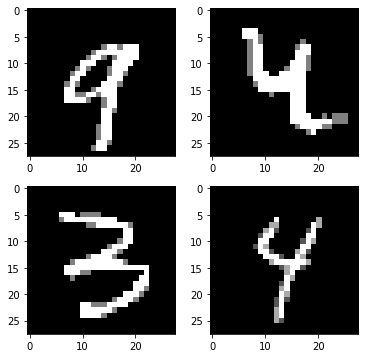

In [236]:
vis_data_normal=next(iter(train_loader))
fig, ax = plt.subplots(2, 2, figsize = (6, 6))
for j in range(0,2):
    for i in range(0,2):
        # ax[i, j].set_title("Label: " + str(vis_data_normal[1][i+(j*2)]), color="red")
        
        ax[i, j].imshow(np.squeeze(vis_data_normal[0][i+(j*2)]), cmap='gray')



In [237]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv1_bn = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv2_bn = nn.BatchNorm2d(16)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # 4*4 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        #self.dropout = nn.Dropout(0.10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.relu(self.conv1_bn(x))
        
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.relu(self.conv2_bn(x))
        
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        #x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
       
        x = self.fc3(x)
        
        return F.log_softmax(x,1)

In [238]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = F.log_softmax(model(X), dim=1)
        loss = loss_fn(pred, y)
        #loss = F.nll_loss(pred,y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [239]:
model = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),0.005)
total_step = len(train_loader)
epoch = 15
model.train()
for t in range(epoch):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(validation_loader, model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
loss: 2.380996  [    0/39900]
loss: 0.189956  [ 2000/39900]
loss: 0.315386  [ 4000/39900]
loss: 0.304280  [ 6000/39900]
loss: 0.308563  [ 8000/39900]
loss: 0.115913  [10000/39900]
loss: 0.348123  [12000/39900]
loss: 0.231539  [14000/39900]
loss: 0.270275  [16000/39900]
loss: 0.118607  [18000/39900]
loss: 0.016277  [20000/39900]
loss: 0.142487  [22000/39900]
loss: 0.030363  [24000/39900]
loss: 0.036755  [26000/39900]
loss: 0.003752  [28000/39900]
loss: 0.026345  [30000/39900]
loss: 0.037162  [32000/39900]
loss: 0.108977  [34000/39900]
loss: 0.295858  [36000/39900]
loss: 0.116415  [38000/39900]
Test Error: 
 Accuracy: 97.5%, Avg loss: 0.088718 

Epoch 2
-------------------------------
loss: 0.028009  [    0/39900]
loss: 0.213961  [ 2000/39900]
loss: 0.019319  [ 4000/39900]
loss: 0.198736  [ 6000/39900]
loss: 0.028757  [ 8000/39900]
loss: 0.025507  [10000/39900]
loss: 0.001486  [12000/39900]
loss: 0.261312  [14000/39900]
loss: 0.451650  [16000/39900

loss: 0.234060  [36000/39900]
loss: 0.001147  [38000/39900]
Test Error: 
 Accuracy: 98.0%, Avg loss: 0.128241 

Epoch 13
-------------------------------
loss: 0.000000  [    0/39900]
loss: 0.000002  [ 2000/39900]
loss: 0.004309  [ 4000/39900]
loss: 0.001302  [ 6000/39900]
loss: 0.000174  [ 8000/39900]
loss: 0.000531  [10000/39900]
loss: 0.000002  [12000/39900]
loss: 0.087063  [14000/39900]
loss: 0.099942  [16000/39900]
loss: 0.000138  [18000/39900]
loss: 0.000001  [20000/39900]
loss: 0.084301  [22000/39900]
loss: 0.027367  [24000/39900]
loss: 0.001006  [26000/39900]
loss: 0.000013  [28000/39900]
loss: 0.000001  [30000/39900]
loss: 0.000003  [32000/39900]
loss: 0.025904  [34000/39900]
loss: 0.001344  [36000/39900]
loss: 0.000987  [38000/39900]
Test Error: 
 Accuracy: 98.5%, Avg loss: 0.155628 

Epoch 14
-------------------------------
loss: 0.000000  [    0/39900]
loss: 0.001549  [ 2000/39900]
loss: 0.009409  [ 4000/39900]
loss: 0.003010  [ 6000/39900]
loss: 0.000594  [ 8000/39900]
loss

In [240]:
torch.save(model.state_dict(), 'model.pth')

In [241]:

# Pytorch requires a class like this as input to dataloader
class DigitDataset(Dataset):
    def __init__(self,X):
        self.image = X/255 
        
    def __len__(self):
        return len(self.image)
    
    def __getitem__(self,idx):
        image = self.image[idx]
        return torch.FloatTensor(image)
    

test_dir = './test.csv'
# load the training data
test_data = pd.read_csv(test_dir)

test_data = np.array(test_data)
test_data = test_data.reshape(-1,1,28,28)

tensor_test = DigitDataset(test_data)

test_loader = DataLoader(tensor_test, batch_size = 1)


#Load model
nn_model = NeuralNetwork()
nn_model.load_state_dict(torch.load('./model.pth'))


#Function to test the data

def test():
    
    nn_model.eval()
    submission = pd.DataFrame(columns=['ImageId','Label'])
    id = 1 #It has to start in 1 accordingly to the rules
    id_list = []
    guess = []
    
    with torch.no_grad():
        for data in tqdm(test_loader):
            
            outputs = nn_model(data)
            
            #Predicts the correct class
            _, predicted = torch.max(outputs.data, 1)
            #print(predicted.item())
            
            #Rows of the output file
            id_list.append(id)
            guess.append(predicted.item())
            
            #Increment for the next id
            id+=1
            
    submission['ImageId'] = id_list
    submission['Label'] = guess
    
    submission.to_csv("submission.csv",index=False)
   

In [242]:
test()

100%|███████████████████████████████████| 28000/28000 [00:13<00:00, 2019.25it/s]
